In [30]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [31]:
def open_image(path, img_size):
    image = Image.open(path)
    if image.size[0] != img_size or image.size[1] != img_size:
        image = image.resize((img_size, img_size))

    return np.array(image.convert("L"))

In [32]:
img_size = 250

all_faces = []
files = os.listdir("dataset_small//train")
M = len(files)
for file in files:
    all_faces.append(open_image("dataset_small//train/" + file, img_size))



# initialize face matrix
face = np.zeros((img_size, img_size))
error_vals = np.zeros(M)
# loop through collection of faces, add to mean face
def get_mean_face():
    mean_face = np.zeros((img_size, img_size))
    for i in range(0, M):
        face = all_faces[i]
        mean_face += face

    return mean_face / M

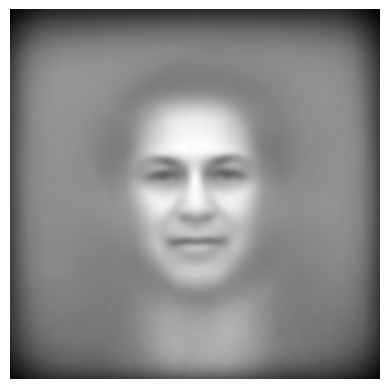

In [33]:
# Perturbation Matrix
# concatenate average face
mean_face = get_mean_face()
mean_face_v = np.matrix.flatten(mean_face, order='F')
P_Matrix = np.zeros((img_size * img_size, M))

for i in range (0, M):
    face = all_faces[i]
    face_v = np.matrix.flatten(face, order='F')
    P_Matrix[:,i] = face_v - mean_face_v

# thin SVD on perturbation marix
u, s, v = np.linalg.svd(P_Matrix, full_matrices=False)

plt.imshow(mean_face, cmap="gray")
plt.axis("off")
plt.show()


In [34]:
def reconstruct(test_img, mask=False):
    imgs = []
    #concatenation
    test_img_v = np.matrix.flatten(test_img, order='F')
    if mask:
        for i in range(len(test_img_v)):
            if random.random() > .8:
                test_img_v[i] = 0
    #initialize reconstructed image as average image to be added to
    reconstructed = mean_face_v
    for i in range(0, M):
        reconstructed += ((np.inner(u[:,i], (test_img_v - mean_face_v)))*u[:,i])
        error_vals[i] = np.linalg.norm(test_img_v - reconstructed)/np.linalg.norm(test_img_v)# scaling values for displaying purposes
        if i % 500 == 0:
            img = np.reshape(reconstructed, (img_size, img_size), order='F')
            img.clip(min=0, max=255, out=img)
            imgs.append(img.astype(np.uint8))

    reconstructed = np.reshape(reconstructed, (img_size, img_size), order='F')
    reconstructed.clip(min=0, max=255, out=reconstructed)
    reconstructed = reconstructed.astype(np.uint8)
    imgs.append(reconstructed)
    test_img = np.reshape(test_img_v, (img_size, img_size), order='F')
    return test_img, imgs


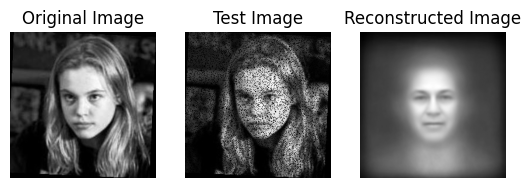

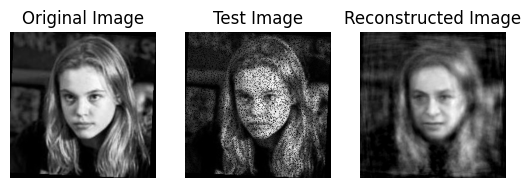

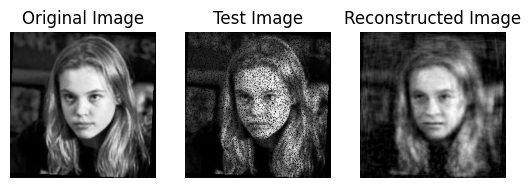

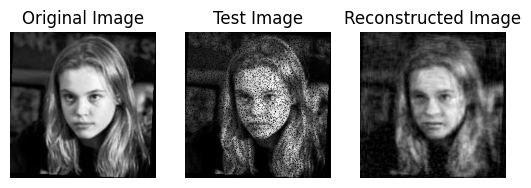

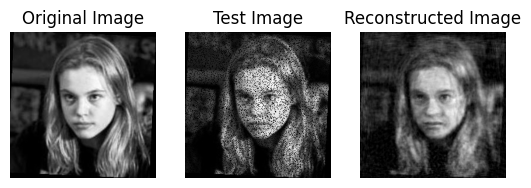

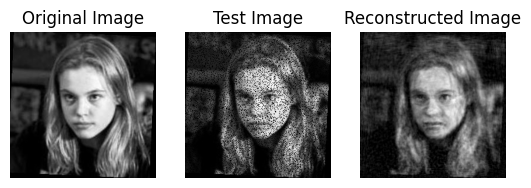

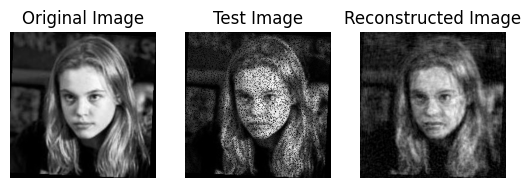

In [35]:
original_img = open_image("dataset_small/test/Agnes_Bruckner_0001.jpg", img_size)
test_img, imgs = reconstruct(original_img, mask=True)
for i in range(len(imgs)):
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(original_img,cmap="gray")
    axes[1].imshow(test_img,cmap="gray")
    axes[2].imshow(imgs[i], cmap="gray")
    axes[0].set_title("Original Image")
    axes[1].set_title("Test Image")
    axes[2].set_title("Reconstructed Image")
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    plt.show()

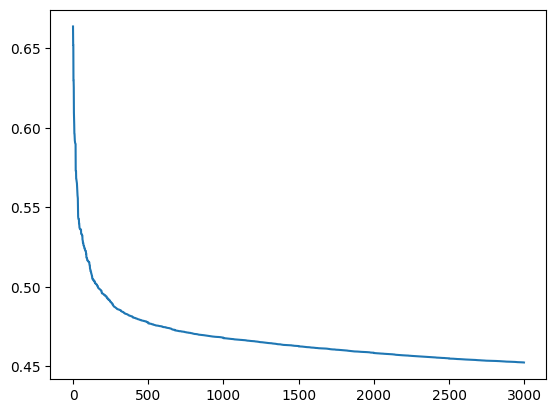

In [36]:
# plt.axis([-20, 1500, .05, .350])
plt.plot(error_vals, "-")